In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import Input, layers
from tensorflow.keras import models
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
# from tqdm import tqdm # replace with this if moving out of notebook

import os
import pathlib

from datetime import datetime as dt

from IPython import display

2.12.0


In [2]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
i16min = -2**15
i16max = 2**15-1
fsamp = 16000
wave_length_ms = 1000
wave_length_samps = int(wave_length_ms*fsamp/1000)
window_size_ms=60
window_step_ms=40
num_filters = 32
use_microfrontend = True
dataset = 'micro-speech'

silence_str = "_silence"  
unknown_str = "_unknown"
EPOCHS = 25

Apply the frontend to an example signal.

In [4]:
commands = ['right', 'stop'] 
if dataset == 'micro-speech':
  data_dir = pathlib.Path('data/mini_speech_commands')

In [5]:
data_dir

WindowsPath('data/mini_speech_commands')

In [6]:
label_list = commands.copy()
label_list.insert(0, silence_str)
label_list.insert(1, unknown_str)
print('label_list:', label_list)

label_list: ['_silence', '_unknown', 'right', 'stop']


In [7]:
if dataset == 'micro-speech':
    filenames = tf.io.gfile.glob(os.path.join(str(data_dir), '*', '*.wav')) 
    filenames = tf.random.shuffle(filenames)
    num_samples = len(filenames)
    print('Number of total examples:', num_samples)
    print('Example file tensor:', filenames[0])

Number of total examples: 8000
Example file tensor: tf.Tensor(b'data\\mini_speech_commands\\left\\ba676390_nohash_1.wav', shape=(), dtype=string)


In [8]:
filenames
# tf.strings.split(filenames[0], os.path.sep)[-2].numpy().decode('utf8')

<tf.Tensor: shape=(8000,), dtype=string, numpy=
array([b'data\\mini_speech_commands\\left\\ba676390_nohash_1.wav',
       b'data\\mini_speech_commands\\down\\eb76bc68_nohash_0.wav',
       b'data\\mini_speech_commands\\left\\f3d06008_nohash_1.wav', ...,
       b'data\\mini_speech_commands\\up\\f00180d0_nohash_0.wav',
       b'data\\mini_speech_commands\\up\\b97c9f77_nohash_1.wav',
       b'data\\mini_speech_commands\\down\\0b77ee66_nohash_0.wav'],
      dtype=object)>

In [9]:
for i in range(10):
    print(filenames[i].numpy().decode('utf8'))

data\mini_speech_commands\left\ba676390_nohash_1.wav
data\mini_speech_commands\down\eb76bc68_nohash_0.wav
data\mini_speech_commands\left\f3d06008_nohash_1.wav
data\mini_speech_commands\down\784e281a_nohash_1.wav
data\mini_speech_commands\go\3f2b358d_nohash_0.wav
data\mini_speech_commands\right\2167c2ed_nohash_1.wav
data\mini_speech_commands\left\bfb10243_nohash_0.wav
data\mini_speech_commands\right\8dd788d8_nohash_0.wav
data\mini_speech_commands\stop\bbd0bbd0_nohash_0.wav
data\mini_speech_commands\no\215699ff_nohash_0.wav


In [10]:
if dataset == 'micro-speech':
  print('Using mini-speech')
  num_train_files = int(0.8*num_samples) 
  num_val_files = int(0.1*num_samples) 
  num_test_files = num_samples - num_train_files - num_val_files
  train_files = filenames[:num_train_files]
  val_files = filenames[num_train_files: num_train_files + num_val_files]
  test_files = filenames[-num_test_files:]
  
print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Using mini-speech
Training set size 6400
Validation set size 800
Test set size 800


In [11]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [12]:
# @tf.function
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  in_set = tf.reduce_any(parts[-2] == label_list)
  label = tf.cond(in_set, lambda: parts[-2], lambda: tf.constant(unknown_str))
  # print(f"parts[-2] = {parts[-2]}, in_set = {in_set}, label = {label}")
  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return  label # parts[-2]

In [13]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [14]:
def get_spectrogram(waveform):
  # Concatenate audio with padding so that all audio clips will be of the 
  # same length (16000 samples)
  zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.int16)
  waveform = tf.cast(0.5*waveform*(i16max-i16min), tf.int16)  # scale float [-1,+1]=>INT16
  equal_length = tf.concat([waveform, zero_padding], 0)
  ## Make sure these labels correspond to those used in micro_features_micro_features_generator.cpp
  spectrogram = frontend_op.audio_microfrontend(equal_length, sample_rate=fsamp, num_channels=num_filters,
                                    window_size=window_size_ms, window_step=window_step_ms)
  return spectrogram


Function to convert each waveform in a set into a spectrogram, then convert those
back into a dataset using `from_tensor_slices`.  (We should be able to use 
`wav_ds.map(get_spectrogram_and_label_id)`, but there is a problem with that process).
   

In [15]:
def create_silence_dataset(num_waves, samples_per_wave, rms_noise_range=[0.01,0.2], silent_label=silence_str):
    # create num_waves waveforms of white gaussian noise, with rms level drawn from rms_noise_range
    # to act as the "silence" dataset
    rng = np.random.default_rng()
    rms_noise_levels = rng.uniform(low=rms_noise_range[0], high=rms_noise_range[1], size=num_waves)
    rand_waves = np.zeros((num_waves, samples_per_wave), dtype=np.float32) # pre-allocate memory
    for i in range(num_waves):
        rand_waves[i,:] = rms_noise_levels[i]*rng.standard_normal(samples_per_wave)
    labels = [silent_label]*num_waves
    return tf.data.Dataset.from_tensor_slices((rand_waves, labels))  

In [16]:
def wavds2specds(waveform_ds, verbose=True):
  wav, label = next(waveform_ds.as_numpy_iterator())
  one_spec = get_spectrogram(wav)
  one_spec = tf.expand_dims(one_spec, axis=0)  # add a 'batch' dimension at the front
  one_spec = tf.expand_dims(one_spec, axis=-1) # add a singleton 'channel' dimension at the back    

  num_waves = 0 # count the waveforms so we can allocate the memory
  for wav, label in waveform_ds:
    num_waves += 1
  print(f"About to create spectrograms from {num_waves} waves")
  spec_shape = (num_waves,) + one_spec.shape[1:] 
  spec_grams = np.nan * np.zeros(spec_shape)  # allocate memory
  labels = np.nan * np.zeros(num_waves)
  idx = 0
  for wav, label in waveform_ds:    
    if verbose and idx % 250 == 0:
      print(f"\r {idx} wavs processed", end='')
    spectrogram = get_spectrogram(wav)
    # TF conv layer expect inputs structured as 4D (batch_size, height, width, channels)
    # the microfrontend returns 2D tensors (freq, time), so we need to 
    spectrogram = tf.expand_dims(spectrogram, axis=0)  # add a 'batch' dimension at the front
    spectrogram = tf.expand_dims(spectrogram, axis=-1) # add a singleton 'channel' dimension at the back
    spec_grams[idx, ...] = spectrogram
    new_label = label.numpy().decode('utf8')
    new_label_id = np.argmax(new_label == np.array(label_list))    
    labels[idx] = new_label_id # for numeric labels
    # labels.append(new_label) # for string labels
    idx += 1
  labels = np.array(labels, dtype=int)
  output_ds = tf.data.Dataset.from_tensor_slices((spec_grams, labels))  
  return output_ds

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
num_train_files = len(train_files)
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
train_ds = wavds2specds(waveform_ds)

About to create spectrograms from 6400 waves
 6250 wavs processed

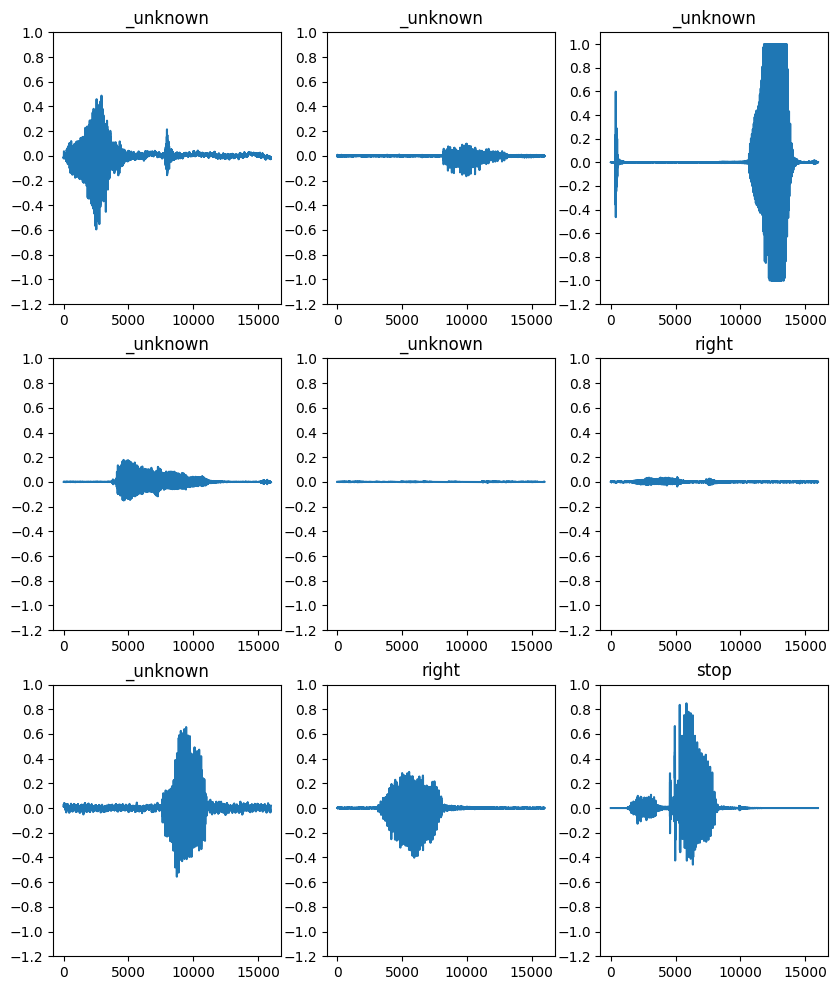

In [18]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [19]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: _unknown
Waveform shape: (16000,)
Spectrogram shape: (24, 32)
Audio playback


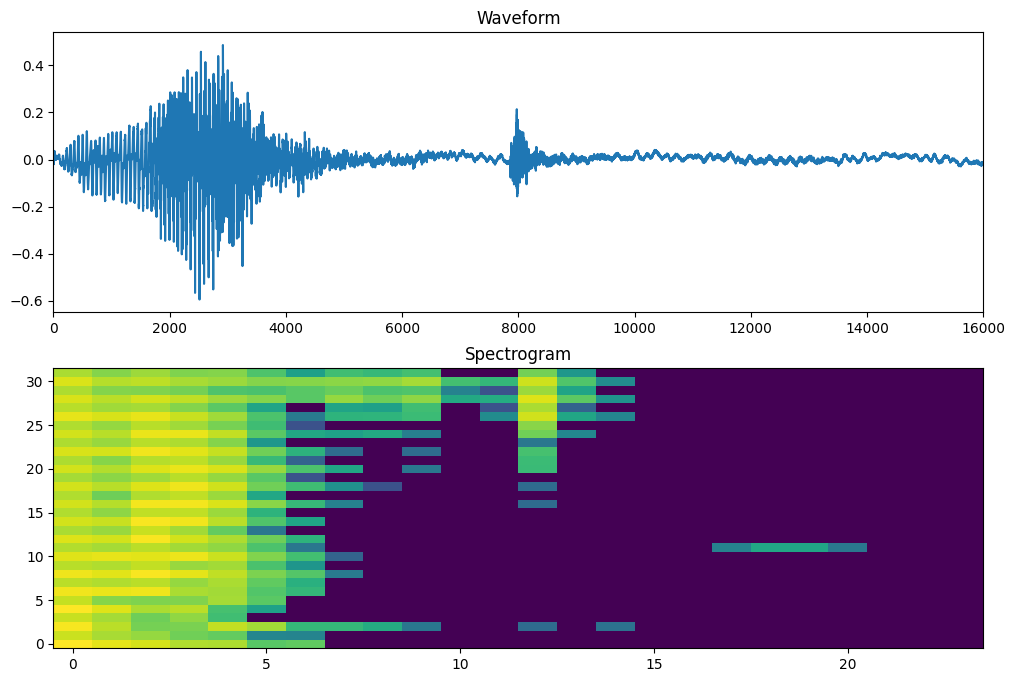

In [20]:
def plot_spectrogram(spectrogram, ax):
  # transpose so that the time is
  # represented in the x-axis (columns).
  freq_bins = spectrogram.shape[1]
  time_dur = spectrogram.shape[0]
  X = np.arange(time_dur)
  Y = range(freq_bins)
  ax.pcolormesh(X, Y, spectrogram.T)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [21]:
spectrogram.numpy().shape

(24, 32)

C:\Users\Naseer\AppData\Local\Temp\ipykernel_18180\1859809011.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax.set_title(label_list[np.int(label_id)])


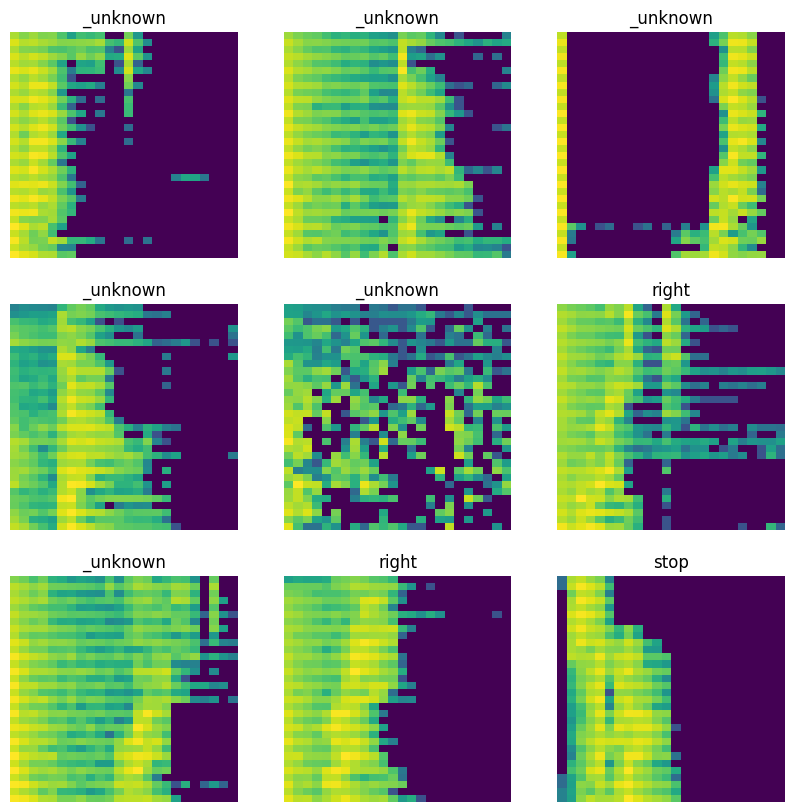

In [22]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(train_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(label_list[np.int(label_id)])
  ax.axis('off')

plt.show()

In [23]:
def copy_with_noise(ds_input, rms_level=0.25):
  rng = tf.random.Generator.from_seed(1234)
  wave_shape = tf.constant((wave_length_samps,))
  def add_noise(waveform, label):
    noise = rms_level*rng.normal(shape=wave_shape)
    zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)    
    noisy_wave = waveform + noise
    return noisy_wave, label

  return ds_input.map(add_noise)

In [24]:
# waveform_ds = augment_with_noise(waveform_ds)
count = 0
for w,l in waveform_ds:
  if w.shape != (16000,):
    print(f"element {count} has shape {w.shape}")
    break
  count += 1
print(count)

element 13 has shape (10403,)
13


In [25]:
def pad_16000(waveform, label):
    zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)        
    return waveform, label

In [26]:
def count_labels(dataset):
    counts = {}
    for _, lbl in dataset:
        if lbl.dtype == tf.string:
            label = lbl.numpy().decode('utf-8')
        else:
            label = lbl.numpy()
        if label in counts:
            counts[label] += 1
        else:
            counts[label] = 1
    return counts

In [27]:
# Collect what we did to generate the training dataset into a 
# function, so we can repeat with the validation and test sets.
def preprocess_dataset(files, num_silent=None, noisy_reps_of_known=None):
  # if noisy_reps_of_known is not None, it should be a list of rms noise levels
  # For every target word in the data set, 1 copy will be created with each level 
  # of noise added to it.  So [0.1, 0.2] will add 2x noisy copies of the target words 
  if num_silent is None:
    num_silent = int(0.2*len(files))+1
  print(f"Processing {len(files)} files")
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  waveform_ds = files_ds.map(get_waveform_and_label)
  if noisy_reps_of_known is not None:
    # create a few copies of only the target words to balance the distribution
    # create a tmp dataset with only the target words
    ds_only_cmds = waveform_ds.filter(lambda w,l: tf.reduce_any(l == commands))
    for noise_level in noisy_reps_of_known:
       waveform_ds = waveform_ds.concatenate(copy_with_noise(ds_only_cmds, rms_level=noise_level))
  if num_silent > 0:
    silent_wave_ds = create_silence_dataset(num_silent, wave_length_samps, 
                                            rms_noise_range=[0.01,0.2], 
                                            silent_label=silence_str)
    waveform_ds = waveform_ds.concatenate(silent_wave_ds)
  print(f"Added {num_silent} silent wavs and ?? noisy wavs")
  print(waveform_ds)
  num_waves = 0
  output_ds = wavds2specds(waveform_ds)
  return output_ds

In [28]:
print(f"We have {len(train_files)}/{len(val_files)}/{len(test_files)} training/validation/test files")

We have 6400/800/800 training/validation/test files


In [29]:
# print(train_files[:20])
print(label_list)
train_files[:20]

tmp_ds = preprocess_dataset(train_files[:20])
print(count_labels(tmp_ds))

with tf.device('/CPU:0'): # needed on M1 mac
    tmp_ds = preprocess_dataset(train_files[:20], noisy_reps_of_known=[0.05,0.1])
    print(count_labels(tmp_ds))



['_silence', '_unknown', 'right', 'stop']
Processing 20 files
Added 5 silent wavs and ?? noisy wavs
<_ConcatenateDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>
About to create spectrograms from 25 waves
 0 wavs processed{1: 16, 2: 3, 3: 1, 0: 5}
Processing 20 files
Added 5 silent wavs and ?? noisy wavs
<_ConcatenateDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>
About to create spectrograms from 33 waves
 0 wavs processed{1: 16, 2: 9, 3: 3, 0: 5}


In [30]:
# train_ds is already done
with tf.device('/CPU:0'): # needed on M1 mac
    train_ds = preprocess_dataset(train_files, noisy_reps_of_known=[0.05,0.1,0.15,0.2,0.25])
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Processing 6400 files
Added 1281 silent wavs and ?? noisy wavs
<_ConcatenateDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>
About to create spectrograms from 15711 waves
 15500 wavs processedProcessing 800 files
Added 161 silent wavs and ?? noisy wavs
<_ConcatenateDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>
About to create spectrograms from 961 waves
 750 wavs processedProcessing 800 files
Added 161 silent wavs and ?? noisy wavs
<_ConcatenateDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>
About to create spectrograms from 961 waves
 750 wavs processed

In [31]:
print("training data set")
print(count_labels(train_ds))
print("val_ds data set")
print(count_labels(val_ds))
print("test_ds data set")
print(count_labels(test_ds))

training data set
{1: 4794, 2: 4806, 3: 4830, 0: 1281}
val_ds data set
{1: 591, 2: 110, 3: 99, 0: 161}
test_ds data set
{1: 615, 2: 89, 3: 96, 0: 161}


In [32]:
train_ds = train_ds.shuffle(int(len(train_files)*1.2))
val_ds = val_ds.shuffle(int(len(val_files)*1.2))
test_ds = test_ds.shuffle(int(len(test_files)*1.2))

In [33]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [34]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [35]:
for spectrogram, _ in train_ds.take(1):
  spec1 = spectrogram
# take(1) takes 1 *batch*, so we have to select the first 
# spectrogram from it, hence the [0]
print(f"Spectrogram shape {spec1[0].shape}")
print(f"ranges from {np.min(spec1)} to {np.max(spec1)}")   # min/max across the whole batch

Spectrogram shape (24, 32, 1)
ranges from 0.0 to 710.0


In [36]:
for spectrogram, _ in train_ds.take(1):
  # take(1) takes 1 *batch*, so we have to select the first 
  # spectrogram from it, hence the [0]
  input_shape = spectrogram[0].shape  
print('Input shape:', input_shape)
num_labels = len(label_list)


Input shape: (24, 32, 1)


In [37]:
print('Input shape:', input_shape)
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(20, 3, activation='relu'),
    layers.MaxPooling2D(name='pool2'),
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),
    layers.Conv2D(32, 1, activation='relu'),
    layers.MaxPooling2D(pool_size=(4,4)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_labels),
], name="simple_cnn")

model.summary()

Input shape: (24, 32, 1)
Model: "simple_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 30, 20)        200       
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 15, 20)        0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 11, 15, 20)       200       
 Conv2D)                                                         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 15, 32)        672       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 3, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (N

In [38]:
# number of MACs in each layer is (# outputs in layer) * (number of inputs that contribute to one output)
macs = np.array([(14*38*20)*(3*3), (7*19*20)*(3*3), (7*19*32)*20, 128*128, 128*128, 4*128])
print(macs)
print(np.sum(macs))

[95760 23940 85120 16384 16384   512]
238100


In [39]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [40]:
#  Google: feature extraction with Keras
# feature_model = tf.keras.model(input=model.input, output= model.layers[4].output)

In [41]:
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS) 
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))

Epoch 1/25
246/246 [==============================] - 4s 14ms/step - loss: 1.9010 - accuracy: 0.4639 - val_loss: 0.8757 - val_accuracy: 0.6670
Epoch 2/25
246/246 [==============================] - 3s 14ms/step - loss: 0.9843 - accuracy: 0.5280 - val_loss: 0.8444 - val_accuracy: 0.6826
Epoch 3/25
246/246 [==============================] - 3s 14ms/step - loss: 0.9146 - accuracy: 0.5475 - val_loss: 0.7965 - val_accuracy: 0.7003
Epoch 4/25
246/246 [==============================] - 3s 14ms/step - loss: 0.8692 - accuracy: 0.5732 - val_loss: 0.7533 - val_accuracy: 0.7222
Epoch 5/25
246/246 [==============================] - 3s 13ms/step - loss: 0.8237 - accuracy: 0.5904 - val_loss: 0.6546 - val_accuracy: 0.7690
Epoch 6/25
246/246 [==============================] - 3s 14ms/step - loss: 0.7713 - accuracy: 0.6292 - val_loss: 0.6044 - val_accuracy: 0.7856
Epoch 7/25
246/246 [==============================] - 3s 14ms/step - loss: 0.7251 - accuracy: 0.6552 - val_loss: 0.5324 - val_accuracy: 0.8221

In [42]:
date_str = dt.now().strftime("%d%b%Y_%H%M").lower()
model_file_name = f"kws_ufe_{date_str}.h5" 
print(f"Saving model to {model_file_name}")
model.save(model_file_name, overwrite=False)

Saving model to kws_ufe_08may2023_2050.h5


In [43]:
with open(model_file_name.split('.')[0] + '.txt', 'w') as fpo:
    fpo.write(f"i16min            = {i16min           }\n")
    fpo.write(f"i16max            = {i16max           }\n")
    fpo.write(f"fsamp             = {fsamp            }\n")
    fpo.write(f"wave_length_ms    = {wave_length_ms   }\n")
    fpo.write(f"wave_length_samps = {wave_length_samps}\n")
    fpo.write(f"window_size_ms    = {window_size_ms   }\n")
    fpo.write(f"window_step_ms    = {window_step_ms   }\n")
    fpo.write(f"num_filters       = {num_filters      }\n")
    fpo.write(f"use_microfrontend = {use_microfrontend}\n")
    fpo.write(f"label_list        = {label_list}\n")
    fpo.write(f"spectrogram_shape = {spectrogram.numpy().shape}\n")


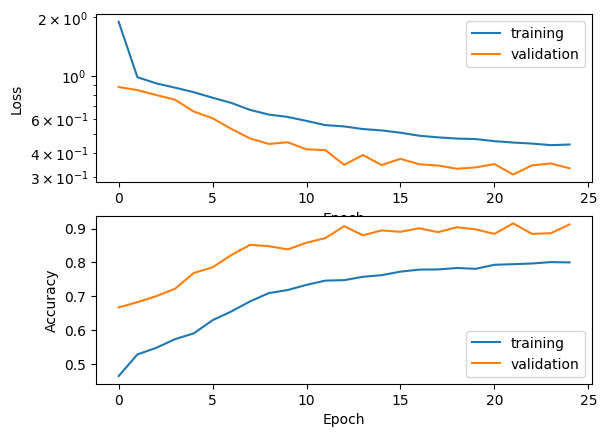

In [44]:
metrics = history.history
plt.subplot(2,1,1)
plt.semilogy(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(2,1,2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [45]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [46]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

31/31 [==============================] - 0s 3ms/step
Test set accuracy: 92%


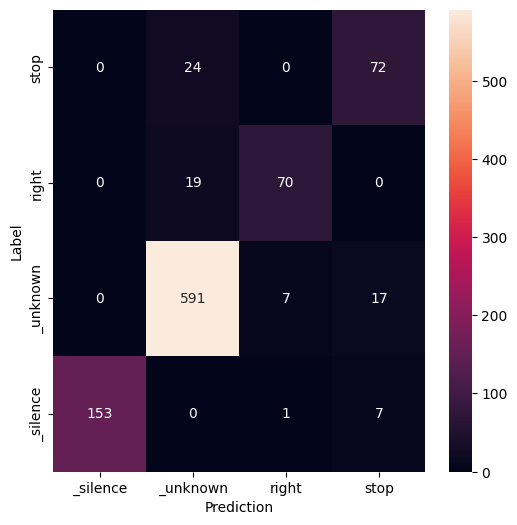

In [47]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

On training set:
491/491 [==============================] - 2s 3ms/step
Data set accuracy: 79%


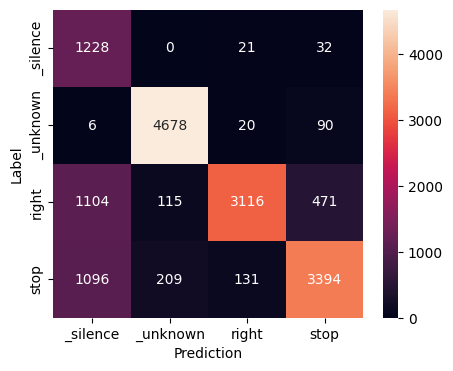

In [48]:
dset = train_ds.unbatch()
print("On training set:")

ds_audio = []
ds_labels = []

for audio, label in dset:
  ds_audio.append(audio.numpy())
  ds_labels.append(label.numpy())

ds_labels = np.array(ds_labels)
ds_audio = np.array(ds_audio)

model_out = model.predict(ds_audio)
y_pred = np.argmax(model_out, axis=1)
y_true = ds_labels

ds_acc = sum(y_pred == y_true) / len(y_true)
print(f'Data set accuracy: {ds_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(5,4))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Processing 4 files
Added 1 silent wavs and ?? noisy wavs
<_ConcatenateDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>
About to create spectrograms from 5 waves
 0 wavs processed

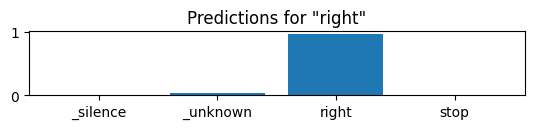

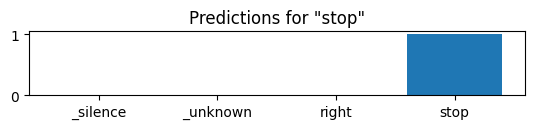

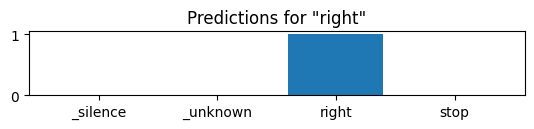

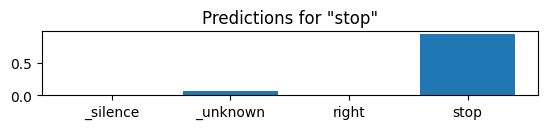

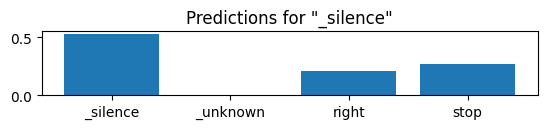

In [50]:
sample_files = [str(data_dir/'right/0ab3b47d_nohash_0.wav'),
                str(data_dir/'stop/0b40aa8e_nohash_0.wav'),
                str(data_dir/'right/fa44fcf5_nohash_2.wav'),
                str(data_dir/'stop/0b56bcfe_nohash_0.wav')]

fstr_list = [str(f) for f in sample_files]
sample_ds = preprocess_dataset(fstr_list, num_silent=1)

count = 1
for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    plt.subplot(len(sample_files)+1, 1, count)
    plt.bar(label_list, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{label_list[label[0]]}"')
    plt.show()
    count += 1

## Quantize and Convert to TFLite

In [51]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [52]:
num_calibration_steps = 10
ds_iter = val_ds.unbatch().batch(1).as_numpy_iterator()
def representative_dataset_gen():
  for _ in range(num_calibration_steps):
    next_input = next(ds_iter)[0]
    next_input = next_input.astype(np.float32)  # (DIFF_FROM_LECTURE)
    yield [next_input]

In [53]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8; should match dat_q in eval_quantized_model.py
converter.inference_output_type = tf.int8  # or tf.uint8

In [54]:
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Naseer\AppData\Local\Temp\tmpm4t8pec5\assets


INFO:tensorflow:Assets written to: C:\Users\Naseer\AppData\Local\Temp\tmpm4t8pec5\assets
c:\Users\Naseer\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\lite\python\convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [55]:
fname = 'kws_model.tflite'
with open(fname, "wb") as fpo:
  num_bytes_written = fpo.write(tflite_quant_model)
print(f"Wrote {num_bytes_written} / {len(tflite_quant_model)} bytes to tflite file")

Wrote 50408 / 50408 bytes to tflite file


In [ ]:
#xxd -i kws_model.tflite >! kws_model.cc